# ベイズ推定

あるデータ$X$が得られた時のパラメータ$\theta$の事後分布を求める。

$$
p(\theta|X)
$$

MAP推定では事後分布が最大となる$\theta$を求めていたが、ベイズ推定では事後分布そのものを求める。

In [1]:
import torch
import pyro.distributions as dist
import matplotlib.pyplot as plt


---

## 解析的に求める

解析的に求めていく。

MAP推定でも使ったこの例題でやってみる。

> 東京都に住む成人男性の平均身長を求めたい。アンケートを実施して、10000の標本を集めることができた。この10000人分のデータを元に、平均身長を求める。具体的には、身長が正規分布に従うと仮定し、その分布の平均値を求める。なお標準偏差は既知で$\sigma=10$とする。また、日本の成人男性の身長が平均170cm、標準偏差10cmの正規分布に従うことを知っているとする。

標本も同じものを使用する。平均174cm、標準偏差10cmの正規分布。

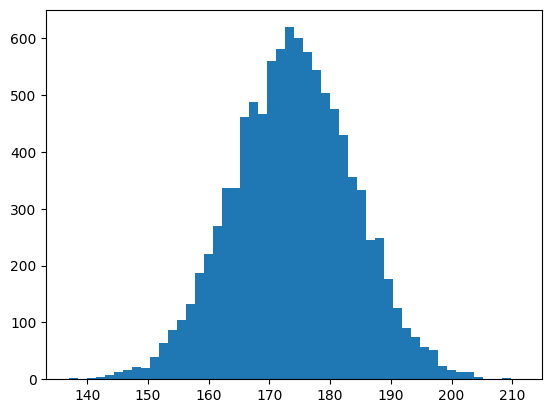

In [2]:
norm = dist.Normal(174, 10)
x = norm.sample((10000,))
plt.hist(x, bins=50);

では求めていく。といっても、普通に計算するだけなんだけどね。  
MAP推定同様、ベイズの定理を使って事後分布を以下のように表す。

$$
p(\theta|X) = \frac{p(X|\theta)p(\theta)}{p(X)}
$$


---

## MCMC法

マルコフ連鎖モンテカルロ法（*Markov Chain Monte Carlo Method*)

求めたい事後分布に従う数列を生成する方法．色々方法がある．

- メトロポリス・ヘイスティング法
- ハミルトニアン・モンテカルロ法
- ギブズサンプリング
- スライスサンプリング


---

## 変分推論

変分ベイズとも

事後分布$P(\theta|x$)を別の分布$q(\theta)$で近似する手法．